Download the training and testing datasets to our local directory.

In [9]:
import requests
from contextlib import closing
import csv

urls = {
        'X_train' : "https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv",
        'y_train' : "https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv",
        'X_test' : "https://s3.amazonaws.com/drivendata/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv"
        }

for i in urls:
    r = requests.get(urls[i])

    text = r.iter_lines()

    reader = csv.reader(text, delimiter=',')

    mylist = list(reader)

    with open(str(i)+'.csv', 'wb') as fp:
        a = csv.writer(fp, delimiter=',')
        data = mylist
        a.writerows(data)

Load our train and test datasets into pandas.

In [319]:
import pandas as pd
import numpy as np

X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

Let's inspect our target variable:

In [68]:
y_train['status_group'].value_counts(normalize = True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [51]:
for i in X_train.columns:
    print i,',' ,'{:.1%}'.format(np.mean(X_train[i].isnull())),'nulls',',',type(X_train[i][0]), X_train[i].nunique()

id , 0.0% nulls , <type 'numpy.int64'> 59400
amount_tsh , 0.0% nulls , <type 'numpy.float64'> 98
date_recorded , 0.0% nulls , <type 'str'> 356
funder , 6.1% nulls , <type 'str'> 1897
gps_height , 0.0% nulls , <type 'numpy.int64'> 2428
installer , 6.2% nulls , <type 'str'> 2145
longitude , 0.0% nulls , <type 'numpy.float64'> 57516
latitude , 0.0% nulls , <type 'numpy.float64'> 57517
wpt_name , 0.0% nulls , <type 'str'> 37400
num_private , 0.0% nulls , <type 'numpy.int64'> 65
basin , 0.0% nulls , <type 'str'> 9
subvillage , 0.6% nulls , <type 'str'> 19287
region , 0.0% nulls , <type 'str'> 21
region_code , 0.0% nulls , <type 'numpy.int64'> 27
district_code , 0.0% nulls , <type 'numpy.int64'> 20
lga , 0.0% nulls , <type 'str'> 125
ward , 0.0% nulls , <type 'str'> 2092
population , 0.0% nulls , <type 'numpy.int64'> 1049
public_meeting , 5.6% nulls , <type 'bool'> 2
recorded_by , 0.0% nulls , <type 'str'> 1
scheme_management , 6.5% nulls , <type 'str'> 12
scheme_name , 47.4% nulls , <type '

In [15]:
X_train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [320]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Variable Clean-up

In [14]:
vars = dict.fromkeys(X_train.columns)

id: we drop the id column because it is not a useful predictor.

In [19]:
def col_id(data):
    del data['id']
    return

amount_tsh: the amount of water available seems like it could be a useful predictor, but since 70% of values have zero, this data is most likely wrong. We shall delete this column.

In [27]:
# 'amount_tsh' is mostly blank - delete
# X_train['amount_tsh'].value_counts(normalize=True)
def col_amount_tsh(data):
    del data['amount_tsh']
    return

date_recorded: this might be a useful variable for this analysis, although the year itself would be useless in a practical scenario moving into the future. We will convert this column into a datetime, and we will also create 'year_recorded' and 'month_recorded' columns just in case those levels prove to be useful. A visual inspection of both casts significant doubt on that possibility, but we'll proceed for now. 

In [49]:
X_train['date_recorded'] = pd.to_datetime(X_train['date_recorded'])
X_train['date_recorded'].apply(lambda x: x.year).value_counts()

2011    28674
2013    24271
2012     6424
2004       30
2002        1
Name: date_recorded, dtype: int64

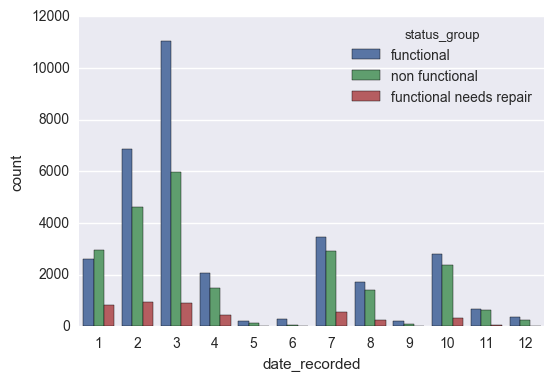

In [56]:
sns.countplot(X_train['date_recorded'].apply(lambda x: x.month), hue = y_train['status_group'])

In [58]:
def col_date_recorded(data):
    data['date_recorded'] = pd.to_datetime(data['date_recorded'])
    data['year_recorded'] = data['date_recorded'].apply(lambda x: x.year).value_counts()
    data['month_recorded'] = data['date_recorded'].apply(lambda x: x.month).value_counts()
    return

funder

In [108]:
def dummies(data, column):
    global X_train, X_test
    good_cols = []
    data[column].fillna('NULL', inplace = True)
    dumms = pd.get_dummies(data[column])
    for i in dumms.columns:
        if chi2_contingency(pd.crosstab(dumms[i], y_train['status_group']))[1] < .001:
            good_cols.append(i)
    X_train = pd.concat((X_train, pd.get_dummies(data[column])[good_cols]), axis = 1)
    print good_cols
    return

`gps_height`, `latitude`, `longitude`

In [323]:
X_train['longitude'] = X_train['longitude'].replace(0., np.NaN)
X_train['latitude'].replace(0., np.NaN, inplace = True)
X_train['gps_height'].replace(0., np.NaN, inplace = True)

In [325]:
data = X_train.groupby(['district_code']).longitude
X_train['longitude'] = data.transform(lambda x: x.fillna(x.mean()))

data = X_train.groupby(['district_code']).latitude
X_train['latitude'] = data.transform(lambda x: x.fillna(x.mean()))

In [324]:
X_train.iloc[21]

id                                          6091
amount_tsh                                     0
date_recorded                         2013-02-10
funder                                      Dwsp
gps_height                                   NaN
installer                                    DWE
longitude                                    NaN
latitude                                  -2e-08
wpt_name                                Muungano
num_private                                    0
basin                              Lake Victoria
subvillage                            Ibabachegu
region                                 Shinyanga
region_code                                   17
district_code                                  1
lga                                      Bariadi
ward                           Ikungulyabashashi
population                                     0
public_meeting                               NaN
recorded_by              GeoData Consultants Ltd
scheme_management   

In [265]:
from numpy import nan

med = X_train.groupby('district_code')['longitude'].transform('mean')
X_train['longitude'].fillna(med)

0        34.938093
1        34.698766
2        37.460664
3        38.486161
4        31.130847
5        39.172796
6        33.362410
7        32.620617
8        32.711100
9        30.626991
10       39.209518
11       35.770258
12       33.798106
13       37.092574
14       34.364073
15       31.444121
16       34.642439
17       34.569266
18       32.920154
19       34.508967
20       34.473430
21             NaN
22       34.586901
23       37.940029
24       29.747066
25       37.422751
26       39.370777
27       31.104257
28       37.611126
29       37.061688
           ...    
59370    30.058731
59371    33.586406
59372    32.058548
59373    32.125024
59374          NaN
59375    39.046942
59376    34.821039
59377    33.437012
59378    34.620387
59379    31.613284
59380    34.942101
59381    38.835001
59382    37.454759
59383    39.626009
59384    30.667805
59385    33.951681
59386    31.738789
59387    39.176480
59388    30.692400
59389    30.646486
59390    31.370848
59391    38.

In [267]:
fill_values = dict(X_train['longitude'].groupby(X_train['district_code']).mean())

fill_func = lambda g: g.fillna(fill_values[g.name])
X_train['longitude'] = X_train['longitude'].groupby(X_train['district_code']).apply(fill_func)

In [326]:
sum(pd.isnull(X_train['longitude']))

0

In [279]:
X_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572.0,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,0.0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776.0,0.0,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,0.0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310.0,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,0.0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743.0,0.0,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0.0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728.0,0.0,2011-07-13,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,0.0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


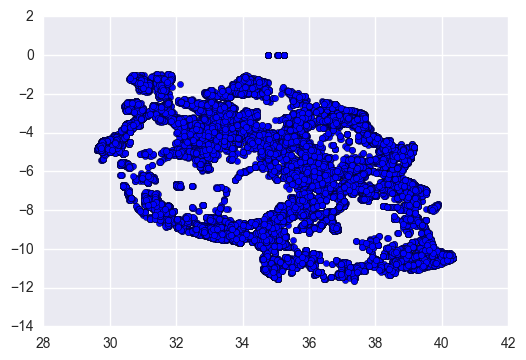

In [327]:
plt.scatter(X_train['longitude'], X_train['latitude'])